<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Step1:-Create-the-substitution-cypher" data-toc-modified-id="Step1:-Create-the-substitution-cypher-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Step1: Create the substitution cypher</a></span></li><li><span><a href="#Step-2:-Download-the-data-to-train-the-model" data-toc-modified-id="Step-2:-Download-the-data-to-train-the-model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Step 2: Download the data to train the model</a></span></li><li><span><a href="#Step-3:-Set-up-an-encoding-and-decoding-function" data-toc-modified-id="Step-3:-Set-up-an-encoding-and-decoding-function-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Step 3: Set up an encoding and decoding function</a></span></li><li><span><a href="#Step-4:-run-an-evolutionary-algorithm-to-decode-the-message" data-toc-modified-id="Step-4:-run-an-evolutionary-algorithm-to-decode-the-message-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Step 4: run an evolutionary algorithm to decode the message</a></span></li><li><span><a href="#Step-5:-look-at-the-results" data-toc-modified-id="Step-5:-look-at-the-results-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Step 5: look at the results</a></span></li></ul></div>

### Introduction ###

In this notebook I have coded alongside a section for building a cypher from Udemy's course presented by the Lazy Programmer entitled 'Data Science: Natural Language Programming in Python.' The section explores the use of an evolutionary algorithm to predict an encoded message. I start by creating a substitution cypher before building a language model based on the Markov matrix. I then download data to train the model, before setting up an encoding and decoding function. Lastly I build the evolutionary algorithm and then run it to see the results and how well it predicts the true text.

In [1]:
#Import the libraries needed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import bamboolib as bam

import random #for shuffling characters
import re #for regex operations
import requests #to request the Moby Dick text file
import os
import textwrap
import string #for manipulating string and ASCII characters

### Step1: Create the substitution cypher ###

The first step is to create a cypher. We develop two lists of letters of the alphabet - one the key, one the values. For the values we randomly shuffle the order. The keys and values are then mapped to an empty disctionary.

In [2]:
# create the cypher where one list of 26 lowercase letters is the key, the other the values
letters1 =list(string.ascii_lowercase)
letters2 =list(string.ascii_lowercase)

# Inititialise an empty dictionary called true mapping, and then work to populate this dictionary. When populated, this is the substition cypher
true_mapping={}

# Randomise the second lsit of letters
random.shuffle(letters2)

# Loop through both lists in corresponding order to populate the list
for k,v in zip(letters1, letters2):
    true_mapping[k]=v


Then we build the language model. A Markov matrix is developed to stort all the bigram possibilities. As there are 26 starting and ending letters we need a 26x26 matrix. We also need a vector to store all the unigram possibilities - this will be the initial state distribution accounting for each individual letter. Functions are then required to update pi and M. For M, the Markov matrix, the function call two variable ch1 and ch2 - the starting and ending characters. We also need to convert the characters to integers using the ord command.<br>
The second function to be built is for the initial state distribution. The third function to be built calculates the log probability for a single word. The function takes a single argument to consider the probability of the first letter for a unigram which is then converted to a log probability. Then we loop through the rest of the characters in the word to work out the log probability. The final function finds the probablity of an entire sequence of words

In [3]:
# Initialise the Markov matrix
M = np.ones((26,26))

# initial state distribution
pi = np.zeros(26)

# build a function to update the Markov matrix
def update_transition (ch1,ch2):
    
    # ord ('a') = 97, ord ('b') = 98 etc
    i = ord(ch1) - 97
    j = ord(ch2) - 97
    M[i,j] += 1
    
# build a function for the initial state distribution
def update_pi(ch):
    i = ord(ch) - 97
    pi[i] += 1

# build a function to get the log probability of a single word
def get_word_prob(word):
    #print ('words:', word)
    i = ord(word[0]) - 97
    logp =np.log(pi[i])
    
    for ch in word[1:]:
        j = ord(ch) - 97
        logp += np.log(M[i, j]) # update probability
        i = j # update j
    return logp

# get the probability for a sequence of words
def get_sequence_prob(words):
    # if the input is a string, break up sequence as an array of tokens
    if type(words) == str:
        words=words.split()
        
    logp = 0
    for word in words:
        logp += get_word_prob(word)
    return logp

### Step 2: Download the data to train the model ###

Here we request the .txt and then write it to a file. And then populate bigram and unigram strutures. We start by using regex to remove non-alpha characters and then use a loop to read in the Moby Dick file line by line, making sure that only lines with words in them appear. Then we lower case all letters in the line and call the split function to get individual words, before looping through each token one by one where we call the functions defined above. And then converting to true probabilities.

In [4]:
# Check there if there is a file called 'Moby Dick. txt' and if not, download it
if not os.path.exists('moby_dick_txt'):
    print ('Downloading moby dick...')
    r=requests.get ('https://lazyprogrammer.me/course_files/moby_dick.txt')
    with open('moby_dick_txt', 'w') as f:
        f.write(r.content.decode())

In [5]:
# Set up a regex to remove any non alpha characters
regex=re.compile('[^a-zA-Z]')

# Then load in the words and remove any white space using rstrip
for line in open('moby_dick_txt'):
    line=line.rstrip()
    
    # Check for blank lines
    if line:
        line=regex.sub(' ', line) # replace all non alpha characters with white space
        
        # split tokens in the line and into lowercase
        tokens=line.lower().split()
        
        for token in tokens: # Update the model
            ch0=token[0] # for the first letter
            update_pi(ch0)
            
            # for other letters
            for ch1 in token[1:]:
                update_transition(ch0, ch1)
        
# normalise the probabilities
pi /= pi.sum()
M /= M.sum(axis=1, keepdims=True)

### Step 3: Set up an encoding and decoding function ### 

Start by selecting a piece of text to encode. ### encode a message. This is a piece of text from Project Gutenburg's 'The Adventures of Sherlock Holmes', by Arthur Conan Doyle. https://www.gutenberg.org/ebooks/1661. Then set up a function to encode the message that converts case to lower. This is followed by creating the encoded message as an empty list, which is iterated over one character at a time before returning the coded message as a file string. Next we set up a decode function that takes two arguments - a cipher text message and a word map. Similarly we create an empty dictionary and the loop through each character before returning the message as a file string.

In [6]:
# Message to encode

### encode a message

# this is a random excerpt from Project Gutenberg's
# The Adventures of Sherlock Holmes, by Arthur Conan Doyle
# https://www.gutenberg.org/ebooks/1661

original_message = '''I then lounged down the street and found,
as I expected, that there was a mews in a lane which runs down
by one wall of the garden. I lent the ostlers a hand in rubbing
down their horses, and received in exchange twopence, a glass of
half-and-half, two fills of shag tobacco, and as much information
as I could desire about Miss Adler, to say nothing of half a dozen
other people in the neighbourhood in whom I was not in the least
interested, but whose biographies I was compelled to listen to.
'''

# Away they went, and I was just wondering whether I should not do well
# to follow them when up the lane came a neat little landau, the coachman
# with his coat only half-buttoned, and his tie under his ear, while all
# the tags of his harness were sticking out of the buckles. It hadn't
# pulled up before she shot out of the hall door and into it. I only
# caught a glimpse of her at the moment, but she was a lovely woman, with
# a face that a man might die for.

# My cabby drove fast. I don't think I ever drove faster, but the others
# were there before us. The cab and the landau with their steaming horses
# were in front of the door when I arrived. I paid the man and hurried
# into the church. There was not a soul there save the two whom I had
# followed and a surpliced clergyman, who seemed to be expostulating with
# them. They were all three standing in a knot in front of the altar. I
# lounged up the side aisle like any other idler who has dropped into a
# church. Suddenly, to my surprise, the three at the altar faced round to
# me, and Godfrey Norton came running as hard as he could towards me.

# Use the encoding function to encode a message using the cipher

def encode_message(msg):
    msg=msg.lower()
    msg=regex.sub(' ', msg)
    
    # Create a loop to build up the coded message
    
    coded_msg=[]
    for ch in msg:
        coded_ch=ch
        if ch in true_mapping:
            coded_ch=true_mapping[ch]
        coded_msg.append(coded_ch)
    
    return''.join(coded_msg)

# Set up a function to decode a message

encoded_message=encode_message(original_message)

def decode_message(msg, word_map):
    decoded_msg=[]
    for ch in msg:
        decoded_ch=ch
        if ch in word_map:
            decoded_ch=word_map[ch]
        decoded_msg.append(decoded_ch)
    
    return''.join(decoded_msg)
    


# Use the decoding function to test guesses


### Step 4: run an evolutionary algorithm to decode the message ###

To initiatlise the alogrithm we need to create a dna pool containing 20 dna strings. We create an empty list and then loop 20 times to create 20 random dna strings of characters. Then shuffle it to create a random mapping before appending it to the dna pool. Next we create a function to evolve offspring that contains two arguments, the dna pool and the number of children each will create. The outer loop will loop through each parent, and the inner loop will loop through the children need to create. To create a child, we copy the dna and then randomly swop the characters at positions j and k before making the switch. When finished we append the offspring list to the parent list to return that as the final population.

In [7]:
# initialise the dna pool
dna_pool =[]
for _ in range(20):
    dna=list(string.ascii_lowercase)
    random.shuffle(dna)
    dna_pool.append(dna)

# Create a function to evolve offspring
def evolve_offspring (dna_pool, n_children):
    offspring=[]
    
    for dna in dna_pool:
        for _ in range(n_children):
            copy = dna.copy()
            j=np.random.randint(len(copy))
            k=np.random.randint(len(copy))
            
            # switch
            tmp=copy[j]
            copy[j]=copy[k]
            copy[k]=tmp
            offspring.append(copy)
            
    return offspring + dna_pool

Now we can build the engine to run the algorithm. We set the parameters of the number of iterations and set variables of things we are interested in. Then we calculate the score for each dna string by creating an empty dictionary where the key is the dna string, and the value is its score, and we populate a map. We call the decoded message function, using the encoded message against the current map, and then use the get sequence probability function to score the likelihood of the coded message. Thereafter we score the score in dna2score. If it is, then we assign all the values to be the current values. Outside of this loop we can calculate the average score of population, and store in the array of scores. As we want to keep the most fit individuals (survival of the fittest), we use the sorted function to sort the results and produce a tuple that shows the dna string and its score. Lastly is a debug step that every few iterations prints out the iteration, score, and best score so far.

In [8]:
num_iters = 1000 # No. of generations of offspring to evolve
scores=np.zeros(num_iters) # This stores the score of each iteration of the loop.
best_dna= None # to keep track of the best dna, best map, and best score
best_map = None
best_score = float('-inf')
for i in range(num_iters):
    if i > 0: # i.e. if not the first iteration
       # get offspring from the current dna pool
        dna_pool = evolve_offspring(dna_pool, 3)

# calculate the score for each dna string
    dna2score={}
    for dna in dna_pool:
    # populate the map
        current_map={}
        for k, v in zip(letters1, dna):
            current_map[k] = v
    
        decoded_message=decode_message(encoded_message, current_map)
        score=get_sequence_prob(decoded_message)
    
        #store the score
        dna2score[''.join(dna)] = score
    
        # record the best score so far
        if score > best_score:
            best_dna = dna
            best_map = current_map
            best_score = score
            
    # average score for this generation
    scores[i] = np.mean(list(dna2score.values()))
                    
    # keep the best 5 dna scores
    sorted_dna = sorted(dna2score.items(), key=lambda x: x[1], reverse=True)
    dna_pool = [list(k) for k,v in sorted_dna[:5]]
                    
    if i % 200 ==0:
        print ("iter:", i, "score:", scores[i], "best so far:", best_score)

iter: 0 score: -1668.3919762040591 best so far: -1453.4499421466649
iter: 200 score: -1101.0651727503323 best so far: -1077.20443926904
iter: 400 score: -1114.885581680003 best so far: -1077.20443926904
iter: 600 score: -1126.5724413318603 best so far: -1077.20443926904
iter: 800 score: -1136.494116294202 best so far: -1077.20443926904


### Step 5: look at the results ###

Start by printing out the log likelihood of the decoded message along with the log likelihood of the true message. We also want to see which letters we got wrong by looping through the true mapping. In the loop, 'pred' is the value in the reverse mapping whilst 'true' is the key in the true mapping. If true is not equal to pred, then print out both letters.

In [9]:
decoded_message=decode_message(encoded_message, best_map)

print ('log-likelihood of decoded message: ', get_sequence_prob(decoded_message))
print('log-likelihood of true message: ', get_sequence_prob(regex.sub(' ', original_message.lower())))

# Which letters got wrong
for true, v in true_mapping.items():
    pred = best_map[v]
    if true != pred:
        print('true: %s, pred: %s' %(true, pred))
        

log-likelihood of decoded message:  -1077.20443926904
log-likelihood of true message:  -1070.3003147401457
true: a, pred: o
true: b, pred: p
true: d, pred: t
true: f, pred: g
true: g, pred: w
true: h, pred: d
true: j, pred: z
true: k, pred: q
true: o, pred: s
true: p, pred: b
true: q, pred: j
true: r, pred: y
true: s, pred: r
true: t, pred: a
true: w, pred: h
true: y, pred: f
true: z, pred: k


In the printout from above we can see that the decoded message has a higher log likelihood that the log likelihood of the true message, and that there are a number of letters that are wrong. This will change when the algorithm runs again because of the randomness in its nature. If the true model has a lower likelihood then the assumptions of the Markov model and bigrams might be too restrictive.

In [10]:
print('Decoded message:\n', textwrap.fill(decoded_message))
print('\nTrue message:\n', original_message)

Decoded message:
 i aden lsunwet tshn ade rayeea ont gsunt  or i exbecaet  adoa adeye
hor o mehr in o lone hdicd yunr tshn pf sne holl sg ade woyten  i lena
ade sraleyr o dont in yuppinw tshn adeiy dsyrer  ont yeceivet in
excdonwe ahsbence  o wlorr sg dolg ont dolg  ahs gillr sg rdow aspoccs
ont or mucd ingsymoaisn or i csult teriye opsua mirr otley  as rof
nsadinw sg dolg o tsken sadey besble in ade neiwdpsuydsst in hdsm i
hor nsa in ade leora inaeyeraet  pua hdsre piswyobdier i hor csmbellet
as liraen as

True message:
 I then lounged down the street and found,
as I expected, that there was a mews in a lane which runs down
by one wall of the garden. I lent the ostlers a hand in rubbing
down their horses, and received in exchange twopence, a glass of
half-and-half, two fills of shag tobacco, and as much information
as I could desire about Miss Adler, to say nothing of half a dozen
other people in the neighbourhood in whom I was not in the least
interested, but whose biographies I was 

By plotting the objective with every iteration we can see it goes up fast and then evens out with further iterations as behaviour converges - this is usually seen with such algorithms, and a good way to check whether the algorithm is working.

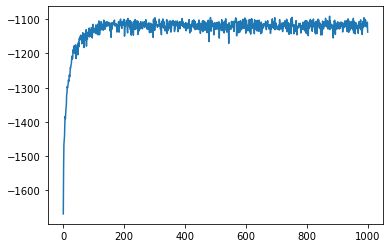

In [11]:
plt.plot(scores)
plt.show;